In [1]:
import os
import torch
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader
from modules.lifter_2d_3d.dataset.simple_keypoint_dataset import SimpleKeypointDataset
from modules.lifter_2d_3d.model.linear_model.lit_linear_model import LitSimpleBaselineLinear
from modules.utils.visualization import (
    generate_connection_line,
    get_sample_from_loader,
    visualize_pose,
    joint_colors,
    joint_sides
)
from IPython.display import display
from pathlib import Path
pl.seed_everything(1234)

# ------------
# dataset path
# ------------
dataset_root_path = Path('/root/data/processed/synthetic_cabin_ir/A_Pillar_Codriver')
keypoint_2d_path = dataset_root_path / 'keypoint_detection_results'
keypoint_3d_path = dataset_root_path / 'annotations'
# ------------
# model
# ------------
image_width = 1280
image_heigth = 1024
batch_size = 64
max_epoch = 10
val_check_period = 5
early_stopping_patience = 5
lit_model = LitSimpleBaselineLinear(exclude_ankle=True, exclude_hip=True)
# ------------
# saved model path
# ------------
saved_model_path = './saved_lifter_2d_3d_model/synthetic_cabin_ir/A_Pillar_Codriver/prediction/linear_model/'


train_dataset = SimpleKeypointDataset(
    prediction_file=(keypoint_2d_path / 'keypoint_detection_train.json').as_posix(),
    annotation_file=(keypoint_3d_path / 'person_keypoints_train.json').as_posix(),
    image_width=1280,
    image_height=1024,
    exclude_ankle=True,
    exclude_hip=True
)
val_dataset = SimpleKeypointDataset(
    prediction_file=(keypoint_2d_path / 'keypoint_detection_val.json').as_posix(),
    annotation_file=(keypoint_3d_path / 'person_keypoints_val.json').as_posix(),
    image_width=1280,
    image_height=1024,
    exclude_ankle=True,
    exclude_hip=True
)
test_dataset = SimpleKeypointDataset(
    prediction_file=(keypoint_2d_path / 'keypoint_detection_test.json').as_posix(),
    annotation_file=(keypoint_3d_path / 'person_keypoints_test.json').as_posix(),
    image_width=1280,
    image_height=1024,
    exclude_ankle=True,
    exclude_hip=True
)

print(
    'train_dataset', len(train_dataset),
    'val_dataset', len(val_dataset),
    'test_dataset', len(test_dataset)
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True, num_workers=24)
val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True, num_workers=24)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=24)

model_checkpoint = ModelCheckpoint(monitor='val_loss',mode='min', save_top_k=1)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=early_stopping_patience)


if not os.path.exists(saved_model_path):
    os.makedirs(saved_model_path)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
trainer = pl.Trainer(
    # max_steps=10,
    max_epochs=max_epoch,
    callbacks=[model_checkpoint, early_stopping],
    accelerator=device,
    check_val_every_n_epoch=val_check_period,
    default_root_dir=saved_model_path,
    gradient_clip_val=1.0
)
trainer.fit(lit_model, train_loader, val_loader)

Global seed set to 1234
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


train_dataset 37499 val_dataset 6250 test_dataset 6251


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params
----------------------------------------
0 | model | BaselineModel | 4.3 M 
----------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.105    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

check #0
val MPJPE from: 128 samples : 4060.011863708496


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

check #1
training loss from 2925 batches: 314.13409610079907
val MPJPE from: 6208 samples : 66.44697487354279


Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


check #2
training loss from 2925 batches: 81.27195040767009
val MPJPE from: 6208 samples : 43.831028044223785


In [2]:
with open(f'{saved_model_path}/best_model_path.txt', 'w') as f:
    f.writelines(model_checkpoint.best_model_path)

In [3]:
best_checkpoint_path = model_checkpoint.best_model_path
trainer.test(ckpt_path=best_checkpoint_path, dataloaders=test_loader)

Restoring states from the checkpoint path at saved_lifter_2d_3d_model/synthetic_cabin_ir/A_Pillar_Codriver/prediction/linear_model/lightning_logs/version_12/checkpoints/epoch=9-step=5850.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at saved_lifter_2d_3d_model/synthetic_cabin_ir/A_Pillar_Codriver/prediction/linear_model/lightning_logs/version_12/checkpoints/epoch=9-step=5850.ckpt


Testing: 0it [00:00, ?it/s]

MPJPE: 47.849325183079905
PJPE
                     PJPE
nose            40.930811
left_eye        47.116935
right_eye       47.757974
left_ear        44.781503
right_ear       51.221956
left_shoulder   37.636695
right_shoulder  42.321936
left_elbow      98.741319
right_elbow     60.942211
left_wrist      54.049714
right_wrist     42.484343
left_hip        34.722864
right_hip       19.332967
activities_mpjpe:
{}
test mpjpe: 47.849325183079905


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           mpjpe           │    47.849325183079905     │
└───────────────────────────┴───────────────────────────┘

[{'mpjpe': 47.849325183079905}]

In [51]:
def plot_images(img_ids, img_paths, gt_kp_2d_list, figsize, colors):
    if len(img_paths) > 1:
        fig, axes = plt.subplots(1, len(img_paths), figsize=figsize)
    else:
        fig, ax = plt.subplots(figsize=figsize)
        axes = [ax]
    for idx, (gt_kp_2d, img_id, img_path) in enumerate(zip(gt_kp_2d_list, img_ids, img_paths)):
        axes[idx].scatter(
            gt_kp_2d[:, 0] * image_heigth,
            gt_kp_2d[:, 1] * image_width,
            c=colors,
            marker='+',
            alpha=.7,
        )
        axes[idx].imshow(plt.imread(img_path))
        axes[idx].set_title(f'Image {img_id}')

def plot_skeleton(gt_kp_3d_list, kp_3d_list, figsize, colors, elev=15., azim=-120 + 45//2, roll=0):
    fig = plt.figure(figsize=figsize)
    axes = []
    for idx, (gt_kp_3d, kp_3d) in enumerate(zip(gt_kp_3d_list, kp_3d_list)):
        # print(idx, len(gt_kp_3d_list))
        if len(gt_kp_3d_list) == 1:
            axes = [plt.axes(projection='3d')]
        else:
            axes.append(fig.add_subplot(1, len(gt_kp_3d_list), idx + 1, projection='3d'))
        # print('len(axes)', len(axes))
        depth = gt_kp_3d[:, 2]
        x = gt_kp_3d[:, 0]
        y = gt_kp_3d[:, 1]
        # plotting
        axes[idx].scatter3D(x, depth, -y, c=colors, marker='o', alpha=.7, depthshade=False)
        depth = kp_3d[:, 2]
        x = kp_3d[:, 0]
        y = kp_3d[:, 1]
        axes[idx].scatter3D(x, depth, -y, c=colors, marker='x', depthshade=False)
        results = generate_connection_line(gt_kp_3d)
        for i in range(len(results) // 2):
            axes[idx].plot3D(
                [results[2*i]['x'], results[2*i + 1]['x']],
                [results[2*i]['z'], results[2*i + 1]['z']],
                [-results[2*i]['y'], -results[2*i + 1]['y']],
            )
        axes[idx].set_xlabel('X')
        axes[idx].set_ylabel('Depth')
        axes[idx].set_zlabel('Y')
        axes[idx].set_xlim([-0.5, -0.5 + 0.8])
        axes[idx].set_zlim([-0.5, -0.5 + 0.8])
        axes[idx].set_ylim([0.7, 0.7 + 0.8])
        axes[idx].xaxis.set_tick_params(labelsize=8)
        axes[idx].yaxis.set_tick_params(labelsize=8)
        axes[idx].zaxis.set_tick_params(labelsize=8)
        axes[idx].view_init(elev=elev, azim=azim, roll=roll)
        # axes[idx].patch.set_facecolor('grey')
        axes[idx].xaxis.set_pane_color((0, 0, 0, .4))
        axes[idx].yaxis.set_pane_color((0, 0, 0, .4))
        axes[idx].zaxis.set_pane_color((0, 0, 0, .4))

In [52]:
def plot_samples(model, figsize, sample_idices):
    model.eval()
    img_ids = []
    img_paths = []
    gt_keypoints_2d_list = []
    gt_keypoints_3d_list = []
    keypoints_3d_list = []

    for sample_idx in sample_idices:
        sample = val_loader.dataset.samples[sample_idx]
        gt_keypoints_3d = sample['keypoints3D']
        gt_keypoints_2d = sample['keypoints2D']
    
        estimated_pose = model(torch.flatten(torch.tensor(sample['keypoints2D'][:, :2])).unsqueeze(0).float().to(model.device), 0)
        keypoints_3d = estimated_pose[0].cpu().reshape([-1, 3]).detach().numpy()
    
        img_path = (dataset_root_path / 'images' / 'val' / sample['filenames']).as_posix()
        img_id = sample['id']
        img_ids.append(img_id)
        img_paths.append(img_path)
        gt_keypoints_3d_list.append(gt_keypoints_3d)
        gt_keypoints_2d_list.append(gt_keypoints_2d)
        keypoints_3d_list.append(keypoints_3d)

    num_joints = gt_keypoints_2d.shape[0]

    plot_images(
        img_ids=img_ids,
        img_paths=img_paths,
        gt_kp_2d_list=gt_keypoints_2d_list,
        figsize=figsize,
        colors=joint_colors[:num_joints]
    )
    plot_skeleton(
        gt_kp_3d_list=gt_keypoints_3d_list,
        kp_3d_list=keypoints_3d_list,
        figsize=figsize,
        colors=joint_colors[:num_joints],
        elev=10., azim=-90 + 45//2, roll=0
    )
    plot_skeleton(
        gt_kp_3d_list=gt_keypoints_3d_list,
        kp_3d_list=keypoints_3d_list,
        figsize=figsize,
        colors=joint_colors[:num_joints],
        elev=0, azim=0
    )

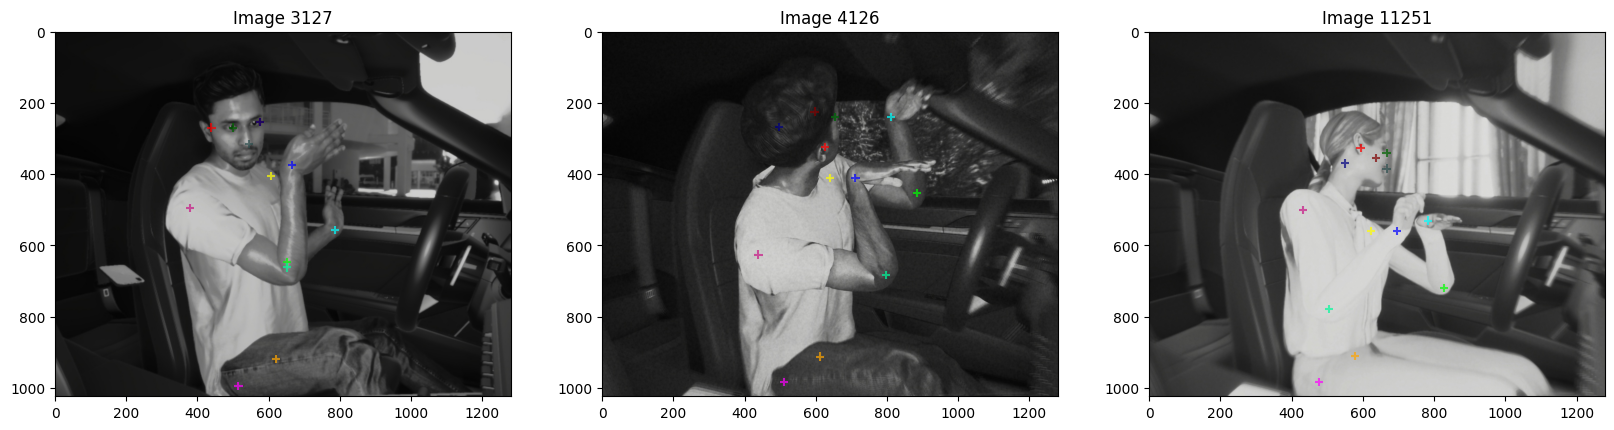

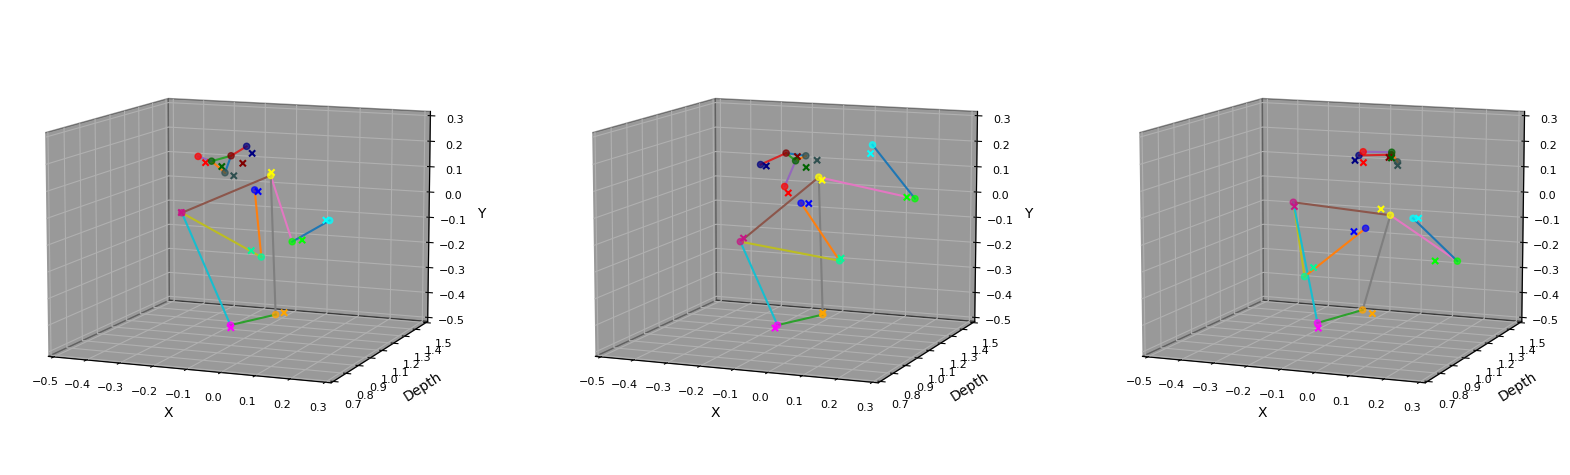

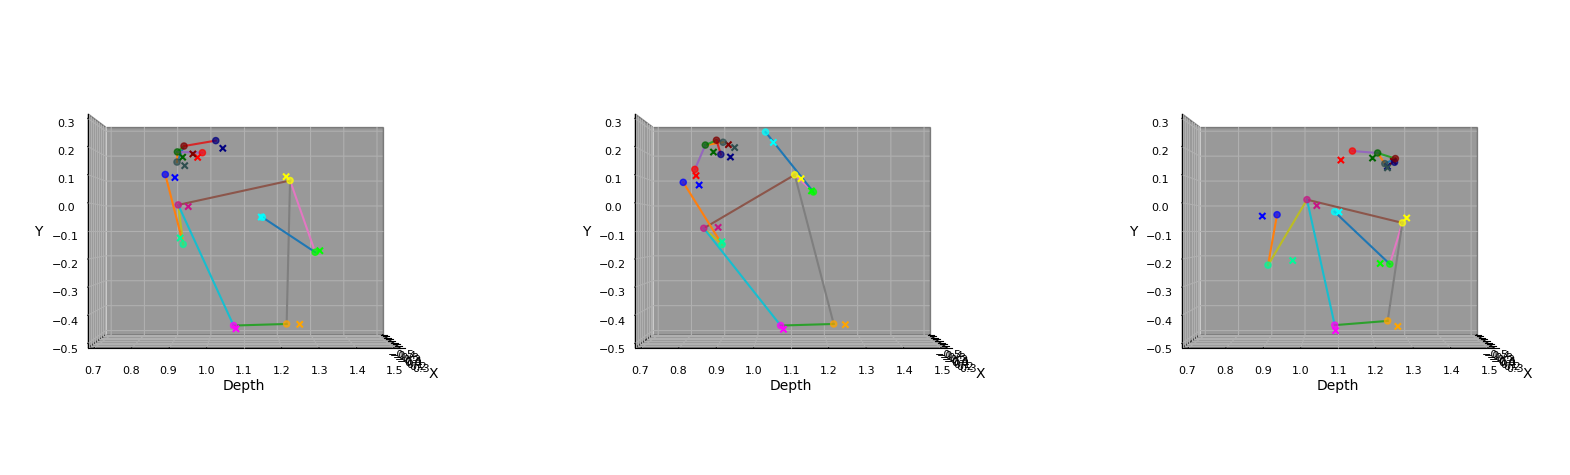

In [53]:
plot_samples(trainer.model, figsize=(20, 10), sample_idices=[1, 1000, 5000])